# MATH-GA 2801.001 Advanced Topics in Equity Derivatives - HW2

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

---

## HW2-1 (a)

Estimate the market price of the 5% call spread (i.e. with strikes ATM and 5% OTM). What
about the 5% put spread?

In [2]:
current = pd.read_csv("HW2_data.csv", header=None).iloc[:4, :2]
options = pd.read_csv("HW2_data.csv", header=None).iloc[5:, :]

In [3]:
current = current.set_index(0)
current

,1
0,
NDX Index,5448
Interest,1.25%
Forward,5460
Tenor,349


The spot price is \\$5448. 

In [4]:
col = options.iloc[0,:]
options.columns = col
call_options = options.iloc[1:,:6]
put_options = options.iloc[1:, 6:]

In [5]:
for option in [call_options, put_options]:
    for column in ["Strike", "Mid"]:
        option[column] = pd.to_numeric(option[column])

In [6]:
def call(F, K, tau, r, sigma):
    '''price a call option by using the BS formula'''
    
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * tau) / (sigma * np.sqrt(tau))
    d2 = (np.log(F / K) - 0.5 * sigma ** 2 * tau) / (sigma * np.sqrt(tau))    
    price = (F * norm.cdf(d1) - K  * norm.cdf(d2)) * np.exp(-r * tau)
    
    return price

def put(F, K, tau, r, sigma):
        
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * tau) / (sigma * np.sqrt(tau))
    d2 = (np.log(F / K) - 0.5 * sigma ** 2 * tau) / (sigma * np.sqrt(tau))    
    price = (K  * norm.cdf(-d2) - F * norm.cdf(-d1)) * np.exp(-r * tau)
    
    return price

In [7]:
def linear_vol(target, lower, upper, lower_vol, upper_vol):
    # linearly interpolate implied volatility
    return lower_vol*(upper-target)/(upper-lower) + upper_vol*(target-lower)/(upper-lower)

To get the ATM options price, we use linear interpolation to get the implied volatility for strike price \$5448.

Read from the table, \\$5448 is between \\$5400 and \\$5450. Since the prices are close.

In [8]:
r = 0.0125
t = 1
F = 5460
S = 5448

In [9]:
ATM_imp_vol = linear_vol(5448, 5400, 5450, 0.156, 0.154)

In [10]:
ATM_call = call(F, S, t, r, ATM_imp_vol)
ATM_put = put(F, S, t, r, ATM_imp_vol)

In [11]:
print('5% OTM strike price for call option is ', (S*1.05))

5% OTM strike price for call option is  5720.400000000001


In [12]:
OTM_imp_vol_call = linear_vol(S*1.05, 5700, 5750, 0.142, 0.14)
call_OTM5 = call(F, S*1.05, t, r, OTM_imp_vol_call)

In [13]:
call_spread = ATM_call - call_OTM5

In [14]:
print('5% OTM strike price for put option is ', (S*0.95))

5% OTM strike price for put option is  5175.599999999999


In [15]:
OTM_imp_vol_put = linear_vol(S*0.95, 5150, 5200, 0.17, 0.167)
put_OTM5 = put(F, S*.95, t, r, OTM_imp_vol_put)

In [16]:
put_spread = ATM_put-put_OTM5

In [17]:
spreads = pd.DataFrame([call_spread, put_spread], index=["Call", "Put"], columns=['ATM & 5% OTM spread']).T

In [18]:
spreads

,Call,Put
ATM & 5% OTM spread,137.8742,95.184568


## HW2-1 (b)

If you were to price the spreads in the Black-Scholes model using a single volatility parameter 𝜎, what
value of 𝜎 would match the theoretical price with the market price? Comment on your results.

---

In [19]:
vol = np.arange(1e-4, 3, 0.0001)

In [20]:
call_ps = np.zeros(vol.shape[0])
for i, v in enumerate(vol):
    # call spreads
    call_ps[i] = call(F, S, t, r, v)-call(F, S*1.05, t, r, v)

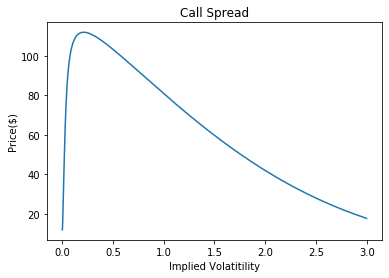

In [21]:
plt.plot(vol, call_ps)
plt.title("Call Spread")
plt.ylabel("Price($)")
plt.xlabel("Implied Volatitility");

We can see that no every spread can be expressed in volatility

In [22]:
print("The maximum of above is ", max(call_ps))

The maximum of above is  112.0133789752216


Therefore, we cannot get the market call spread \\$137.8742 from a single volatility.

In [23]:
put_ps = np.zeros(vol.shape[0])
for i, v in enumerate(vol):
    # put spreads
    put_ps[i] = put(F, S, t, r, v)-put(F, S*0.95, t, r, v)

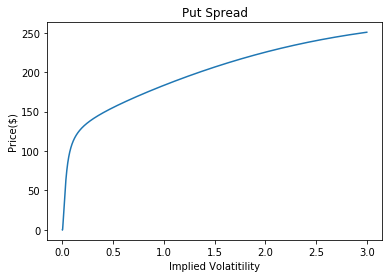

In [24]:
plt.plot(vol, put_ps)
plt.title("Put Spread")
plt.ylabel("Price($)")
plt.xlabel("Implied Volatitility");

On the other hand, we can get market put spread in a single implied volatitility.

In [25]:
the_put_vol = minimize(lambda x : np.abs(put(F, S, t, r, x) - put(F, S*0.95, t, r, x)-put_spread), x0=0.03).x[0]

In [26]:
print(f"When implied volatility is {the_put_vol*100}%, the theoretical spread matches the market spread.")

When implied volatility is 6.616891805028207%, the theoretical spread matches the market spread.


Comment:The call spread as a function of volatility has a maximum value \\$112. The ATM and 5\% OTM call spread is around \\$138, which means we cannot find the coreponsed volatility for such a spread. However, the put spread can be priced with a single volatility parameter. As we show above, 6.6\% is the volatility that match market put spread. However, compared it with the market implied volatility, which is around 14-15\%, this is way off.



---

## HW2-2 (a)

Using the numerical package of your choice, calibrate the parameters of the SVI model
against the market-implied volatility data. Show a comparative graph of the SVI curve and the actual
implied volatility data points.

In [27]:
def SVI(X, a, b, rho, m, s):
    return np.sqrt(a+b*(rho*(np.log(X)-m)+np.sqrt((np.log(X)-m)**2+s**2)))

In [28]:
KF = np.array(call_options["Strike"])/5460

In [29]:
market_vol = (np.array(call_options["Implied Vol. %"].str.strip('%').astype(float)))/100

In [30]:
popt, pcov = curve_fit(SVI, KF, market_vol, bounds=([0,0, -1, -np.inf, 0], [np.inf, np.inf, 1, np.inf, np.inf]),)

In [31]:
a, b, rho, m, s = popt

In [32]:
print(f"The calibrated parameters of the SVI model is a={a}, b={b}, rho={rho}, m={m}, s={s}")

The calibrated parameters of the SVI model is a=0.011140419053628964, b=0.048434365896675796, rho=-0.9999999999999999, m=0.11655027136061491, s=0.08588802353877122


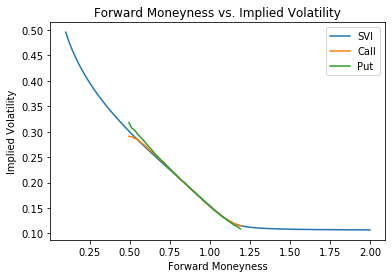

In [33]:
x = np.arange(0.1, 2.01, 0.01)
plt.plot(x, SVI(x, a, b, rho, m, s), label="SVI")
plt.plot(call_options["Strike"]/5460, call_options["Implied Vol. %"].str.strip('%').astype(float)/100, label="Call")
plt.plot(call_options["Strike"]/5460, put_options["Implied Vol. %"].str.strip('%').astype(float)/100, label="Put")
plt.legend()
plt.title("Forward Moneyness vs. Implied Volatility")
plt.ylabel("Implied Volatility")
plt.xlabel("Forward Moneyness");

---

## HW2-2 (b)

Compute or estimate the price of an at-the-money digital call option paying off $1 if in one year NDX
is greater than its current spot level, and zero otherwise: (i) in the Black-Scholes model, (ii) using ±1%
call spreads, (iii) using the smile-adjusted formula on page 19

(i)

The spot price is \\$5448.

In [34]:
def digital_call(F, K, T, r, sigma):
    d2 = (np.log(F / K) - 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T)) 
    return np.exp(-r*T)*norm.cdf(d2)

In [35]:
DBS = digital_call(5460, 5448, t, r, SVI(5448/5460, a, b, rho, m, s))

In [36]:
print("The digital call price from BS is ", DBS)

The digital call price from BS is  0.46889024554520764


(ii)

In [37]:
ATM_call = call(5460, 5448, t, r, SVI(5448/5460, a, b, rho, m, s))

In [38]:
print("The -1% strike is ", 5448*.99)
print("The +1% strike is ", 5448*1.01)

The -1% strike is  5393.5199999999995
The +1% strike is  5502.4800000000005


In [39]:
imp_vol_99 = SVI(5448*.99/5460, a, b, rho, m, s)
imp_vol_101 = SVI(5448*1.01/5460, a, b, rho, m, s)
call_99 = call(5460, 5448*.99, t, r, imp_vol_99)
call_101 = call(5460, 5448*1.01, t, r, imp_vol_101)

In [40]:
spread99 = call_99-ATM_call
spread101 = ATM_call - call_101

In [41]:
print("The ATM digital call option price using call spread is ", (spread99+spread101)/(2*5448*.01))

The ATM digital call option price using call spread is  0.5799752297874559


(iii)

$$
D(S,K,r,T)=D_{BS}(S,K,r,T,\sigma^*(K,T))-V_{BS}(S,K,r, T, \sigma^*(K,T))\frac{\partial\sigma^*}{\partial K}
$$

$$
V_{BS}(S,K,r, T, \sigma^*(K,T))=Se^{-qT}N'(d_1)\sqrt{T}=Fe^{-rT}N'(d_1)\sqrt{T}
$$

$$
\frac{\partial\sigma^*}{\partial K}=\frac{b[\rho+\frac{ln K_F -m}{\sqrt{(ln K_F-m)^2+s^2}}]}{2K\sigma^*}
$$

In [42]:
def vega(F, K, r, T, sigma):
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    N_prime = np.exp(-d1**2/2)/np.sqrt(2*np.pi)
    return np.exp(-r*T)*F*N_prime*np.sqrt(T)

In [43]:
def volK(F, K, a, b, rho, m, s):
    LKF= np.log(K/F)
    temp = (LKF-m)/np.sqrt((LKF-m)**2+s**2)   
    top = b*(rho+temp)
    return top/(2*K*SVI(K/F, a, b, rho, m, s))

In [44]:
VBS = vega(5460, 5448, r, t, SVI(5448/5460, a, b, rho, m, s))
vol_K = volK(5460, 5448, a, b, rho, m, s)

In [45]:
print("The ATM digital call option price using smile-adjusted formula is ", DBS-VBS*vol_K)

The ATM digital call option price using smile-adjusted formula is  0.5801822019473606


(c)

Graph the implied distribution corresponding to the SVI model calibration.

Numerically estimate $\frac{\partial^2\sigma^*}{\partial K^2}$

In [46]:
def volKK(F, K, a, b, rho, m, s, step=1e-6):
    '''
    numerically estimate second derivative
    '''
    pre = volK(F, K-step/2, a, b, rho, m, s)
    nex = volK(F, K+step/2, a, b, rho, m, s)
    return (nex-pre)/step

In [47]:
def imp_dist(F, K, r, T, a=a, b=b, rho=rho, m=m, s=s, step=1e-10):
    '''
    compute the impied distribution density
    '''
    KF = K/F
    sigma = SVI(KF, a, b, rho, m, s)
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = (np.log(F / K) - 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    dsdK = volK(F, K, a, b, rho, m, s)
    dssdKK = volKK(F, K, a, b, rho, m, s, step)
    N_prime = np.exp(-d2**2/2)/np.sqrt(2*np.pi)
    factor = N_prime/(K*sigma*np.sqrt(T))
    term1 = 2*d1*K*dsdK*np.sqrt(T)
    term2 = d1*d2*(K*dsdK*np.sqrt(T))**2
    term3 = (K**2)*dssdKK*sigma*T
    return factor*(1+term1+term2+term3)

In [48]:
Kx = np.arange(1, 2*F+1, 1)

In [49]:
impdist = np.zeros(Kx.shape[0])
for i, k in enumerate(Kx):
    impdist[i] = imp_dist(F, k, r, t)

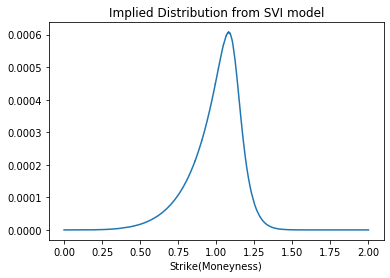

In [50]:
plt.plot(Kx/F, impdist)
plt.title("Implied Distribution from SVI model")
plt.xlabel("Strike(Moneyness)");

(d)

Use the implied distribution to compute the price of the following European exotic options, where 𝑋0
is the current index level and $𝑋_𝑇$ is the final index level:
1. Digital call defined in question (b)
2. “Reverse convertible” paying off $max (100\%, 100\% + 𝑝 \frac{X_T-X_0}{X_0})$ if $\frac{X_T}{X_0} > 75\%$ and $\frac{X_T}{X_0}$ otherwise, where 𝑝 = 50%. Then solve for 𝑝 to get a price of 100%.
3. Option paying off $max (0, \frac{X_T-X_0}{X_T})$
4. Log-contract paying off $−2\ln{\frac{X_T}{X_0}}$. Price interpretation?

(i)

In [51]:
greaterS = np.arange(5448, 2*F, 0.01)
pr = (imp_dist(5460, greaterS, r, t)*0.01).sum()

In [52]:
print("The digital option price from implied distribution is ", np.exp(-r*t)*pr)

The digital option price from implied distribution is  0.5802118514299149


(ii)

In [53]:
step = 0.01
Sx = np.arange(0.1, 2*F, step)
# calculate an array of implied distribution probability
pr = imp_dist(5460, Sx, r, t)*step

In [54]:
def rev_cov(F, S, r, t, pr, p=0.5, ratio=.75, step=0.01, a=a, b=b, rho=rho, m=m, s=s):
    '''
    calculate the price of reverse convertible
    '''
    Sx = np.arange(0.1, 2*F, step)
    x = Sx/S
    temp = 1+p*(x-1)
    payoff = np.where(x>0.75, np.where(1<temp, temp, 1), x)
    price = (payoff*pr).sum()
    return np.exp(-r*t)*price
            

In [55]:
rc_price = rev_cov(F, S, r, t, pr)

In [56]:
print(f"The price of Reverse convertible is {rc_price*100}%")

The price of Reverse convertible is 99.03384637409032%


In [57]:
def objective(p,):
    return np.abs(rev_cov(F, S, r, t, pr, p=p)-1)

In [58]:
op_p = minimize(objective, x0=0.5,)

In [59]:
print(f"p that gets a price of 100% is {op_p.x[0]}")

p that gets a price of 100% is 0.6555125758579129


(iii)

In [60]:
payoff = np.where((Sx-5448)/Sx>0, (Sx-5448)/Sx, 0)

In [61]:
print(f"The price for option with payoff in (iii) is {np.exp(-r*t)*(payoff*pr).sum()}")

The price for option with payoff in (iii) is 0.05402489803383357


(iv)

In [62]:
payoff = -2*np.log(Sx/5448)
print(f"The price of the log-contract payoff option is {np.exp(-r*t)*(payoff*pr).sum()}")

The price of the log-contract payoff option is 0.025826549867520678


The price is same as the price of long a unit of variance swap and short 2 units of return of the stock.

$$
\mathbb{E}[-2ln\frac{S_T}{S_0}] = \mathbb{E}[\int_{0}^{T}\sigma_t^2dt-2\int_{0}^{T}\frac{1}{S_t}dS_t]
$$

## HW2-3

Consider a function 𝑓: (0, ∞) → ℝ whose derivative 𝑓′ exists and is
absolutely continuous. The first-order Taylor series of 𝑓 at point 𝑎 > 0 with remainder in integral form is
then, for all 𝑥 > 0:
$$𝑓(𝑥) = 𝑓(𝑎) + 𝑓′(𝑎)(𝑥 − 𝑎) + \int_a^x𝑓′′(𝑡)(𝑥 − 𝑡)𝑑𝑡$$
(Due to absolute continuity of 𝑓′ on the closed interval between 𝑎 and 𝑥 the derivative 𝑓′′ exists as an
integrable function.)

---

### (a) 

Show that the remainder may be rewritten as:
$∫_0^a𝑓′′(𝑡) max(0, 𝑡 − 𝑥) 𝑑𝑡 + \int_a^\infty𝑓′′(𝑡) max(0, 𝑥 − 𝑡) 𝑑𝑡$

$$ \int_{a}^{x} f''(t)(x-t) dt $$

Let $$z = x-t \implies z = z_{+} + [-(-z)_{+}] = z_{+} - (-z)_{+}$$

Then
$$ \int_{a}^{x} f''(t)(x-t) dt = \int_{a}^{x} f''(t)z dt = \int_{a}^{x} f''(t)[z_{+} - (-z)_{+}] dt $$ <br>
$$ = \int_{a}^{x} f''(t)z_{+}dt - \int_{a}^{x} f''(t)(-z)_{+}dt $$ <br>
$$ = \int_{a}^{x} f''(t)z_{+}dt + \int_{x}^{a} f''(t)(-z)_{+}dt $$ <br>
$$ = \int_{a}^{x} f''(t)max(0, x-t)dt + \int_{x}^{a} f''(t)max(0, t-x)dt $$

Since
$$ \int_{a}^{x} f''(t)max(0, x-t)dt = \int_{a}^{\infty} f''(t)max(0, x-t)dt - \int_{x}^{\infty} f''(t)max(0, x-t)dt = \int_{a}^{\infty} f''(t)max(0, x-t)dt$$ <br>

$$ \int_{0}^{x} f''(t)max(0, t-x)dt = \int_{0}^{a} f''(t)max(0, t-x)dt + \int_{a}^{x} f''(t)max(0, t-x)dt = \int_{0}^{a} f''(t)max(0, t-x)dt$$

We get
$$\int_{a}^{x} f''(t)(x-t) dt = \int_{a}^{x} f''(t)z_{+}dt + \int_{x}^{a} f''(t)(-z)_{+}dt = \int_{a}^{\infty} f''(t)max(0, x-t)dt + \int_{0}^{a} f''(t)max(0, t-x)dt\ \ \blacksquare $$

### (b)

Use your result to show that the variance swap strike pricing formula is:
$$
K_{var}^2=\frac{2e^{rT}}{T}\int_0^F\frac{dK}{K^2}p(K)+\frac{2e^{rT}}{T}\int_F^\infty\frac{dK}{K^2}c(K)
$$
where 𝑟 is the risk-free rate, 𝐹 is the underlying asset’s forward price, and 𝑝(𝐾), 𝑐(𝐾) respectively denote
put or call prices for strike K. 

$$ K^{2}_{var} = \frac{2}{T}\mathrm{E}\left(-ln\frac{S_{T}}{F}\right)$$

$$ -ln\frac{S_{T}}{F} = 1 - \frac{S_{T}}{F} + \int_{F}^{S_{T}} \frac{1}{K^{2}}(S_{T}-K)dK$$

From part (a), we have
$$ \int_{a}^{x} f''(t)(x-t) dt = \int_{a}^{\infty} f''(t)max(0, x-t)dt + \int_{0}^{a} f''(t)max(0, t-x)dt$$

Let
$$ f(x) = -ln(x)\ \forall x > 0$$

Then
$$ f\left(\frac{S_{T}}{F}\right) = 1 - \frac{S_{T}}{F} + \int_{0}^{F} f''(k)max(K-S_{T},0)dK + \int_{F}^{\infty} f''(k)max(S_{T}-K,0)dK$$ <br>

$$ \implies \mathrm{E}[f(\frac{S_{T}}{F})] = 0 + \int_{0}^{F} \frac{1}{K^{2}}\mathrm{E}[max(K-S_{T},0)] dK + \int_{F}^{\infty} \frac{1}{K^{2}}\mathrm{E}[max(S_{T}-K,0)]dK $$ <br>

$$ = \int_{0}^{F} \frac{1}{K^{2}}e^{rT}p(K) dK + \int_{F}^{\infty} \frac{1}{K^{2}}e^{rT}c(K)dK$$ <br>

$$ = e^{rT} [\int_{0}^{F}\frac{dK}{K^{2}}p(K) + \int_{F}^{\infty} \frac{dK}{K^{2}}c(K)]$$ <br>

Hence
$$ K^{2}_{var} = \frac{2}{T}\mathrm{E}\left(-ln\frac{S_{T}}{F}\right) = \frac{2e^{rT}}{T}[\int_{0}^{F}\frac{dK}{K^{2}}p(K) + \int_{F}^{\infty} \frac{dK}{K^{2}}c(K)]\ \ \ \ \blacksquare$$

## HW2-4

Consider an underlying stock S currently
trading at S0 = 100 which does not pay any dividend. Assume the local volatility function is 
$$\sigma_{loc}(𝑡, 𝑆) =
0.1 + \frac{0.1−0.15×ln(\frac{S}{S_0})}{\sqrt{t}}
$$
, and that interest rates are zero.

---

#### (a) Local Volatility Surface

In [63]:
def loc_vol(t, S, S0=100):
    vol = 0.1 + ((0.1-0.15*np.log(S/S0))/np.sqrt(t))
    return vol

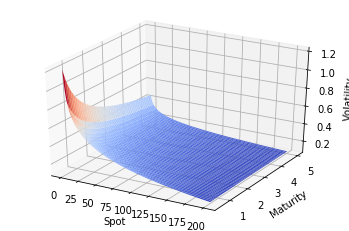

In [64]:
Maturity = np.linspace(0.5, 5, 200) 
Spot = np.linspace(1, 201, 200)

Z = [[loc_vol(j, i) for i in Spot] for j in Maturity]
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(Spot, Maturity)
surf = ax.plot_surface(X,Y, np.array(Z), cmap=cm.coolwarm)
ax.set_xlabel('Spot')
ax.set_ylabel('Maturity')
ax.set_zlabel('Volatility')
plt.show();

#### (b) Price the Options (10000 Simulations)

In [65]:
def GBM(S0, r, T): 
    '''Construct a GBM path'''
    
    dt = 1/T
    dWt = np.random.normal(0, np.sqrt(dt), T)
    t = np.linspace(0, 1-1e-6, T+1)
    S = [0] * (T+1)
    
    S[0] = S0
    tau = 1 - t[0]
    sig = loc_vol(tau, S0+1e-6, S0)
    
    for i in range(1, T+1):
        S[i] = S[i-1] + sig * S[i-1] * dWt[i-1]
        if S[i] < 0:
            S[i] = 1e-6
        tau = 1 - t[i]
        sig = loc_vol(tau, S[i], S0)
    
    return S

In [66]:
S0 = 100
r = 0
T = 252
sim = 10000

cq_price = 0
asian_price = 0
barr_price = 0

for i in range(sim):
    S = GBM(S0, r, T)
    S25 = S[len(S)//4]
    S50 = S[len(S)//2]
    S75 = S[len(S)//4*3]
    S100 = S[-1]
    
    cq_price += min(1, S100**2/S0**2)
    asian_price += max(0, (S25+S50+S75+S100)/(4*S0)-1)
    
    barr = all(p >= 80 for p in S)
    if barr == True:
        barr_price += max(0, S100-S0)
        
cq_price /= sim
asian_price /= sim
barr_price /= sim

In [67]:
print("The price of the \"Capped quadratic\" option is", cq_price)
print("The price of the Asian ATM call option is", asian_price)
print("The price of the Barrier call option is", barr_price)

The price of the "Capped quadratic" option is 0.7952992288526821
The price of the Asian ATM call option is 0.0659964086031927
The price of the Barrier call option is 11.584647477676096
